In [3]:
import ast

import numpy as np
import pandas as pd
from datetime import timedelta
from currency_converter import CurrencyConverter
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats.mstats import winsorize
import geopandas as gpd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import  RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
pd.options.display.float_format = '{:.4f}'.format

## Nhập và hiển thị dữ liệu

In [4]:
#Read and display the dataset
df = pd.read_csv('./Dataset/raw_movies_data.csv', index_col='id')
df.head(10)

title num-of-voters  \
id                                             
0                          '71        59,310   
1           500 Days of Summer       545,530   
2          10 Cloverfield Lane       348,110   
3   10 Things I Hate About You       372,492   
4                    10,000 BC       134,565   
5               101 Dalmatians       116,024   
6                 12 Angry Men       843,351   
7                    12 Strong        89,978   
8             12 Years a Slave       730,399   
9                    127 Hours       394,816   

                          release-year certificate  length  \
id                                                           
0    October 10, 2014 (United Kingdom)          15  1h 39m   
1   September 2, 2009 (United Kingdom)         12A  1h 35m   
2      March 18, 2016 (United Kingdom)         12A  1h 43m   
3        July 9, 1999 (United Kingdom)          12  1h 37m   
4      March 14, 2008 (United Kingdom)         12A  1h 49m   
5   December 13, 1996 (United Kingdom)           U  1h 43m   
6       April 10, 1957 (United States)           U  1h 36m   
7    January 26, 2018 (United Kingdom)          15  2h 10m   
8    January 10, 2014 (United Kingdom)          15  2h 14m   
9     January 7, 2011 (United Kingdom)          15  1h 34m   

                         genres          director  \
id                                                  
0        Action, Crime, Drama,       Yann Demange   
1      Comedy, Drama, Romance,          Marc Webb   
2      Drama, Horror, Mystery,   Dan Trachtenberg   
3      Comedy, Drama, Romance,         Gil Junger   
4    Action, Adventure, Drama,    Roland Emmerich   
5    Adventure, Comedy, Crime,      Stephen Herek   
6                Crime, Drama,       Sidney Lumet   
7      Action, Drama, History,    Nicolai Fuglsig   
8   Biography, Drama, History,      Steve McQueen   
9            Biography, Drama,        Danny Boyle   

                                               writer  \
id                                                      
0                                       Gregory Burke   
1                  Scott Neustadter, Michael H. Weber   
2       Josh Campbell, Matt Stuecken, Damien Chazelle   
3   Karen McCullah, Kirsten Smith, William Shakesp...   
4                      Roland Emmerich, Harald Kloser   
5                            Dodie Smith, John Hughes   
6                                       Reginald Rose   
7                Ted Tally, Peter Craig, Doug Stanton   
8                        John Ridley, Solomon Northup   
9            Danny Boyle, Simon Beaufoy, Aron Ralston   

                                          cast  \
id                                               
0                     Jack O'Connell, Sam Reid   
1        Zooey Deschanel, Joseph Gordon-Levitt   
2        John Goodman, Mary Elizabeth Winstead   
3                   Heath Ledger, Julia Stiles   
4                 Camilla Belle, Steven Strait   
5                    Glenn Close, Jeff Daniels   
6                     Henry Fonda, Lee J. Cobb   
7             Chris Hemsworth, Michael Shannon   
8   Chiwetel Ejiofor, Michael Kenneth Williams   
9                  James Franco, Amber Tamblyn   

                                  language  \
id                                           
0                                  English   
1                 English, French, Swedish   
2                                  English   
3                          English, French   
4                                  English   
5                         English, Spanish   
6                                  English   
7   English, Dari, Russian, Spanish, Uzbek   
8                                  English   
9                         English, Italian   

                                              company  \
id                                                      
0   Film 4, British Film Institute (BFI), Screen Y...   
1   Searchlight Pictures, Watermark, Dune Entertai...   

In [5]:
#The dataset include 17 columns and 4014 rows
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4077 entries, 0 to 4076
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   title            4077 non-null   object 
 1   num-of-voters    4077 non-null   object 
 2   release-year     4077 non-null   object 
 3   certificate      4069 non-null   object 
 4   length           4077 non-null   object 
 5   genres           4077 non-null   object 
 6   director         4077 non-null   object 
 7   writer           4077 non-null   object 
 8   cast             4077 non-null   object 
 9   language         4076 non-null   object 
 10  company          4077 non-null   object 
 11  origin           4077 non-null   object 
 12  budget           3675 non-null   object 
 13  domestic-gross   3702 non-null   object 
 14  worldwide-gross  3908 non-null   object 
 15  rating           4077 non-null   float64
 16  metascore        3902 non-null   float64
 17  metauser         40

<strong> Có thể thấy các cột budget, worldwide-gross, metauser, length và release year, num-of-voters đang có kiểu dữ liệu không phù hợp

## Quan sát và biến đổi các giá trị trong bộ dữ liệu

Chuyển đổi dữ liệu cột num-of-voters thành kiểu integer

In [6]:
#Turn num-of-voters to integer
df['num-of-voters'] = df['num-of-voters'].apply(lambda x: int(x.replace(",", '')))
df['num-of-voters'].info()

<class 'pandas.core.series.Series'>
Index: 4077 entries, 0 to 4076
Series name: num-of-voters
Non-Null Count  Dtype
--------------  -----
4077 non-null   int64
dtypes: int64(1)
memory usage: 63.7 KB


 Chuyển dữ liệu cột release-year thành kiểu dữ liệu datetime

In [7]:
# Convert data in release-year to datetime
def convert_datetime(data):
    try:
        return pd.to_datetime(data.split(' (')[0], format='%B %d, %Y')
    except:
        return pd.to_datetime(data.split(' (')[0])


In [8]:
df['release-year'] = df['release-year'].apply(lambda x: convert_datetime(x))
df['release-year'].info()

<class 'pandas.core.series.Series'>
Index: 4077 entries, 0 to 4076
Series name: release-year
Non-Null Count  Dtype         
--------------  -----         
4077 non-null   datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 63.7 KB


Chuyển dữ liệu cột length thành integer với đơn vị là phút

In [9]:
#Convert data in length column to minutes
def to_duration(data):
    try:
        hour = int(data.split('h')[0])
        try:
            min = int(data.split('h ')[1].replace('m', ''))
        except:
            min = 0
        
        delta = timedelta(hours=hour,
                          minutes=min)
    except:
        min = int(data.replace('m', ''))
        delta = timedelta(hours=0,
                          minutes=min)
        
    return delta

In [10]:
df['length'] = df['length'].apply(lambda x: to_duration(x).seconds/60)
df['length'].info()

<class 'pandas.core.series.Series'>
Index: 4077 entries, 0 to 4076
Series name: length
Non-Null Count  Dtype  
--------------  -----  
4077 non-null   float64
dtypes: float64(1)
memory usage: 63.7 KB


Chuyển đổi dữ liệu trong các cột budget, domestic-gross, worldwide-gross thành integer với đơn vị là Dollar

In [11]:
#Get the currency symbol in the dataset
def get_currency(data : pd.DataFrame):
    currency = []
    for col in data:
        for row in data[col]:
            if pd.isnull(row):
                pass 
            else:
                row = row.replace(" (estimated)", "")
                curr = ''.join(x for x in row if x.isdigit() == False).replace(',', '').replace('\xa0', '').replace(" ", '')
                if curr not in currency:
                    currency.append(curr)
    return currency

print(get_currency(df[['budget', 'domestic-gross', 'worldwide-gross']]))

['$', '₹', '€', 'ESP', '₩', '¥', '£', 'RUR', 'A$', 'FRF', 'DKK', 'R$', 'CA$', 'TRL', 'DEM', 'ITL', 'SEK', 'NOK', 'ATS', 'CN¥']


In [12]:
#Create a dictionary to convert currency symbols into currency code
curr_sym_to_code = {"$": "USD",
                    "\u20b9": "INR",
                    "\u20ac": "EUR",
                    "\u20a9": "KRW",
                    "\u00a5": "JPY",
                    "A$": "AUD",
                    "\u00a3": "GBP",
                    "R$": "BRL",
                    "CA$": "CAD",
                    "DEM": "DEM",
                    "FRF": "FRF",
                    "ITL": "ITL",
                    "SEK": "SEK",
                    "NOK": "NOK",
                    "DKK": "DKK",
                    "ATS": "ATS",
                    "CN\u00a5": "CNY",
                    "RUR": "RUB",
                    "ESP": "ESP",
                    "TRL": "TRL"}
curr_sym_to_code

{'$': 'USD',
 '₹': 'INR',
 '€': 'EUR',
 '₩': 'KRW',
 '¥': 'JPY',
 'A$': 'AUD',
 '£': 'GBP',
 'R$': 'BRL',
 'CA$': 'CAD',
 'DEM': 'DEM',
 'FRF': 'FRF',
 'ITL': 'ITL',
 'SEK': 'SEK',
 'NOK': 'NOK',
 'DKK': 'DKK',
 'ATS': 'ATS',
 'CN¥': 'CNY',
 'RUR': 'RUB',
 'ESP': 'ESP',
 'TRL': 'TRL'}

In [13]:
#Convert all the data in budget, domestic-gross, worldwide-gross to the same unit and to integer
def clean_and_convert_money(data: str):
    if pd.isnull(data):
        return data
    else:
        data = data.replace(" (estimated)", "")
        money = int(''.join(x for x in data if x.isdigit()))
        curr = ''.join(x for x in data if x.isdigit() == False).replace(',', '').replace('\xa0', '').replace(" ", '')
        cr = CurrencyConverter()
        if curr_sym_to_code[curr] not in ['DEM', 'FRF', 'ITL', 'ATS', 'ESP', 'TRL']:
            output = cr.convert(money, curr_sym_to_code[curr], 'USD')
        elif curr_sym_to_code[curr] == 'DEM':
            output = cr.convert(money, 'EUR', 'USD') * 0.51129188
        elif curr_sym_to_code[curr] == 'FRF':
            output = cr.convert(money, 'EUR', 'USD') * 0.15244902
        elif curr_sym_to_code[curr] == 'ITL':
            output = cr.convert(money, 'EUR', 'USD') * 0.0005164569
        elif curr_sym_to_code[curr] == 'ATS':
            output = cr.convert(money, 'EUR', 'USD') * 0.072672834
        elif curr_sym_to_code[curr] == 'ESP':
            output = cr.convert(money, 'EUR', 'USD') * 0.006010121
        elif curr_sym_to_code[curr] == 'TRL':
            output = cr.convert(money, 'EUR', 'USD') * 0.031827769
        return int(output)

In [14]:
df['budget'] = df['budget'].apply(lambda x: clean_and_convert_money(x))
df['domestic-gross'] = df['domestic-gross'].apply(lambda x: clean_and_convert_money(x))
df['worldwide-gross'] = df['worldwide-gross'].apply(lambda x: clean_and_convert_money(x))

Chuyển đổi kiểu dữ liệu biến metauser thành integer

In [15]:
def k_to_thousand(num):
    if 'K' in num:
        return int(float(num.replace('K', '')) * 1000)
    else:
        return int(num)

In [16]:
df['metauser'] = df['metauser'].apply(lambda x: k_to_thousand(x))
df['metauser'].info()

<class 'pandas.core.series.Series'>
Index: 4077 entries, 0 to 4076
Series name: metauser
Non-Null Count  Dtype
--------------  -----
4077 non-null   int64
dtypes: int64(1)
memory usage: 63.7 KB


In [17]:
df['metacritic'] = df['metacritic'].apply(lambda x: k_to_thousand(x))
df['metacritic'].info()

<class 'pandas.core.series.Series'>
Index: 4077 entries, 0 to 4076
Series name: metacritic
Non-Null Count  Dtype
--------------  -----
4077 non-null   int64
dtypes: int64(1)
memory usage: 63.7 KB


## Xử lý các giá trị bị khuyết

In [18]:
df.isna().sum()

title                0
num-of-voters        0
release-year         0
certificate          8
length               0
genres               0
director             0
writer               0
cast                 0
language             1
company              0
origin               0
budget             402
domestic-gross     375
worldwide-gross    169
rating               0
metascore          175
metauser             0
metacritic           0
dtype: int64

Thay thế các giá trị bị thiếu trong các cột budget, domestic-gross, worldwide-gross, metascore bằng giá trị trung bình của các cột

In [19]:
df['budget'].fillna(int(df['budget'].mean()), inplace=True)
df['domestic-gross'].fillna(int(df['domestic-gross'].mean()), inplace=True)
df['worldwide-gross'].fillna(int(df['worldwide-gross'].mean()), inplace=True)
df['metascore'].fillna(int(df['metascore'].mean()), inplace=True)

Loại bỏ các hàng bị thiếu language và certificate vì số lượng không đáng kể

In [20]:
df.dropna(subset=['certificate', 'language'], inplace=True)

Chuyển đổi các cột dữ liệu có chứa các biến phân loại để dễ dàng hơn trong việc phân tích
Với biến language, origin và company sẽ lấy giá trị đầu tiên của ô giá trị đó

In [21]:
df['genres'] = df['genres'].apply(lambda x: x[:-2].split(', '))
df['writer'] = df['writer'].apply(lambda x: x.split(', '))
df['director'] = df['director'].apply(lambda x: x.split(', ')[0])
df['cast'] = df['cast'].apply(lambda x: x.split(', '))
df['language'] = df['language'].apply(lambda x: x.split(', ')[0])
df['company'] = df['company'].apply(lambda x: x.split(', ')[0])
df['origin'] = df['origin'].apply(lambda x: x.split(', ')[0])

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4068 entries, 0 to 4076
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   title            4068 non-null   object        
 1   num-of-voters    4068 non-null   int64         
 2   release-year     4068 non-null   datetime64[ns]
 3   certificate      4068 non-null   object        
 4   length           4068 non-null   float64       
 5   genres           4068 non-null   object        
 6   director         4068 non-null   object        
 7   writer           4068 non-null   object        
 8   cast             4068 non-null   object        
 9   language         4068 non-null   object        
 10  company          4068 non-null   object        
 11  origin           4068 non-null   object        
 12  budget           4068 non-null   float64       
 13  domestic-gross   4068 non-null   float64       
 14  worldwide-gross  4068 non-null   float64     

In [23]:
df.isna().sum()

title              0
num-of-voters      0
release-year       0
certificate        0
length             0
genres             0
director           0
writer             0
cast               0
language           0
company            0
origin             0
budget             0
domestic-gross     0
worldwide-gross    0
rating             0
metascore          0
metauser           0
metacritic         0
dtype: int64

## Xử lý giá trị ngoại lệ

In [24]:
numerical_columns = ['budget', 'domestic-gross', 'worldwide-gross', 'rating', 'metascore', 'metauser', 'metacritic', 'num-of-voters']

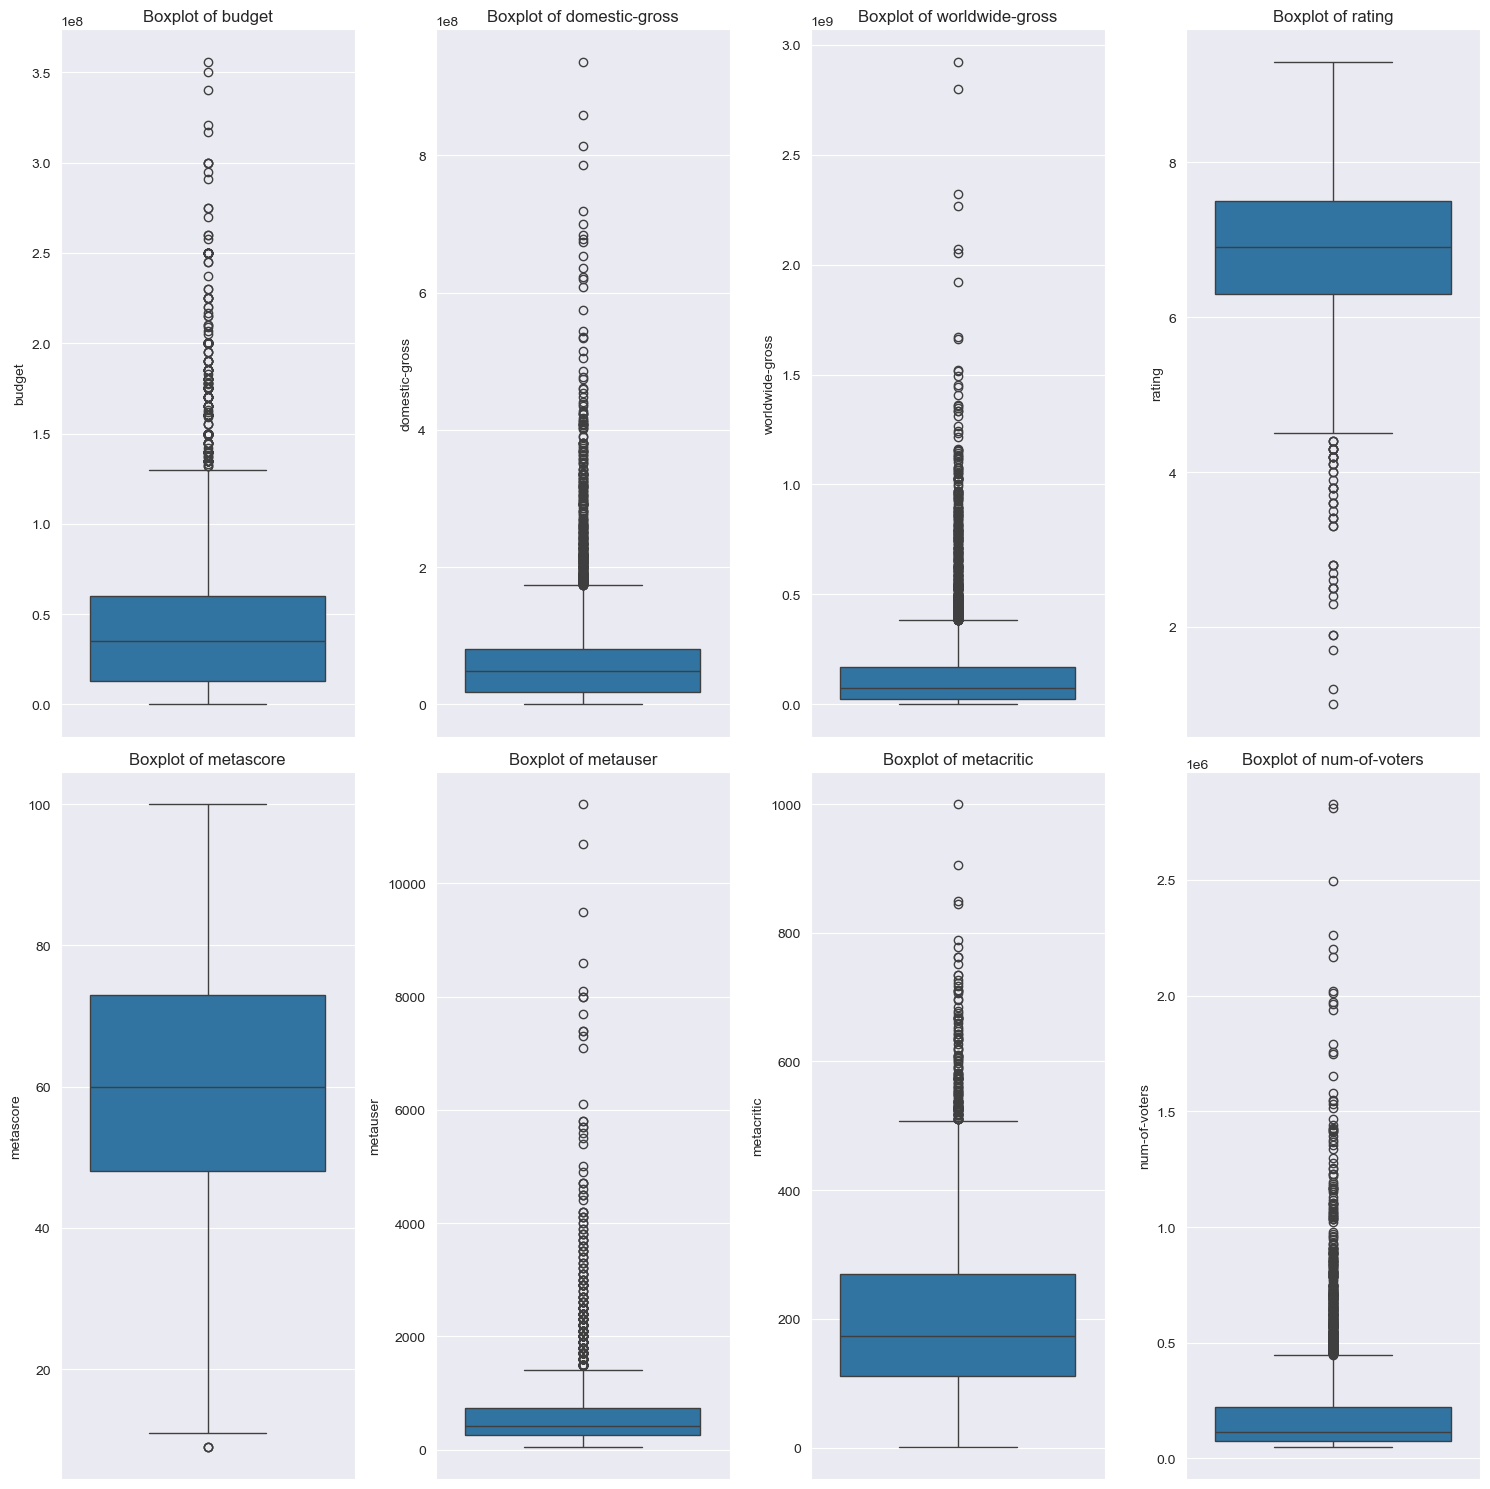

In [25]:
#Detect outlier using boxplot
fig, axs = plt.subplots(2, 4, figsize=(15, 15))
for i, var in enumerate(numerical_columns):
    sns.boxplot(df[var], ax=axs[i//4, i%4])
    axs[i//4, i%4].set_title('Boxplot of ' + var)
plt.tight_layout()
plt.show()

<strong> Các biến số có một số giá trị ngoại lệ nhưng đây không phải do lỗi mà là do dữ liêu bị lệch vì vậy thay vì loại bỏ thì em sử dụng phương pháp winsorize để giải quyết ngoại lệ.

In [26]:
from scipy.stats.mstats import winsorize
#Create a function to winsorize outliers
def outlier_handler(data: pd.DataFrame):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5*IQR
    upper_limit = Q3 + 1.5*IQR
    return winsorize(data, limits=[data.where(data < lower_limit).count()/data.count(), data.where(data > upper_limit).count()/data.count()])

In [27]:
for col in numerical_columns:
    df[col] = outlier_handler(df[col])

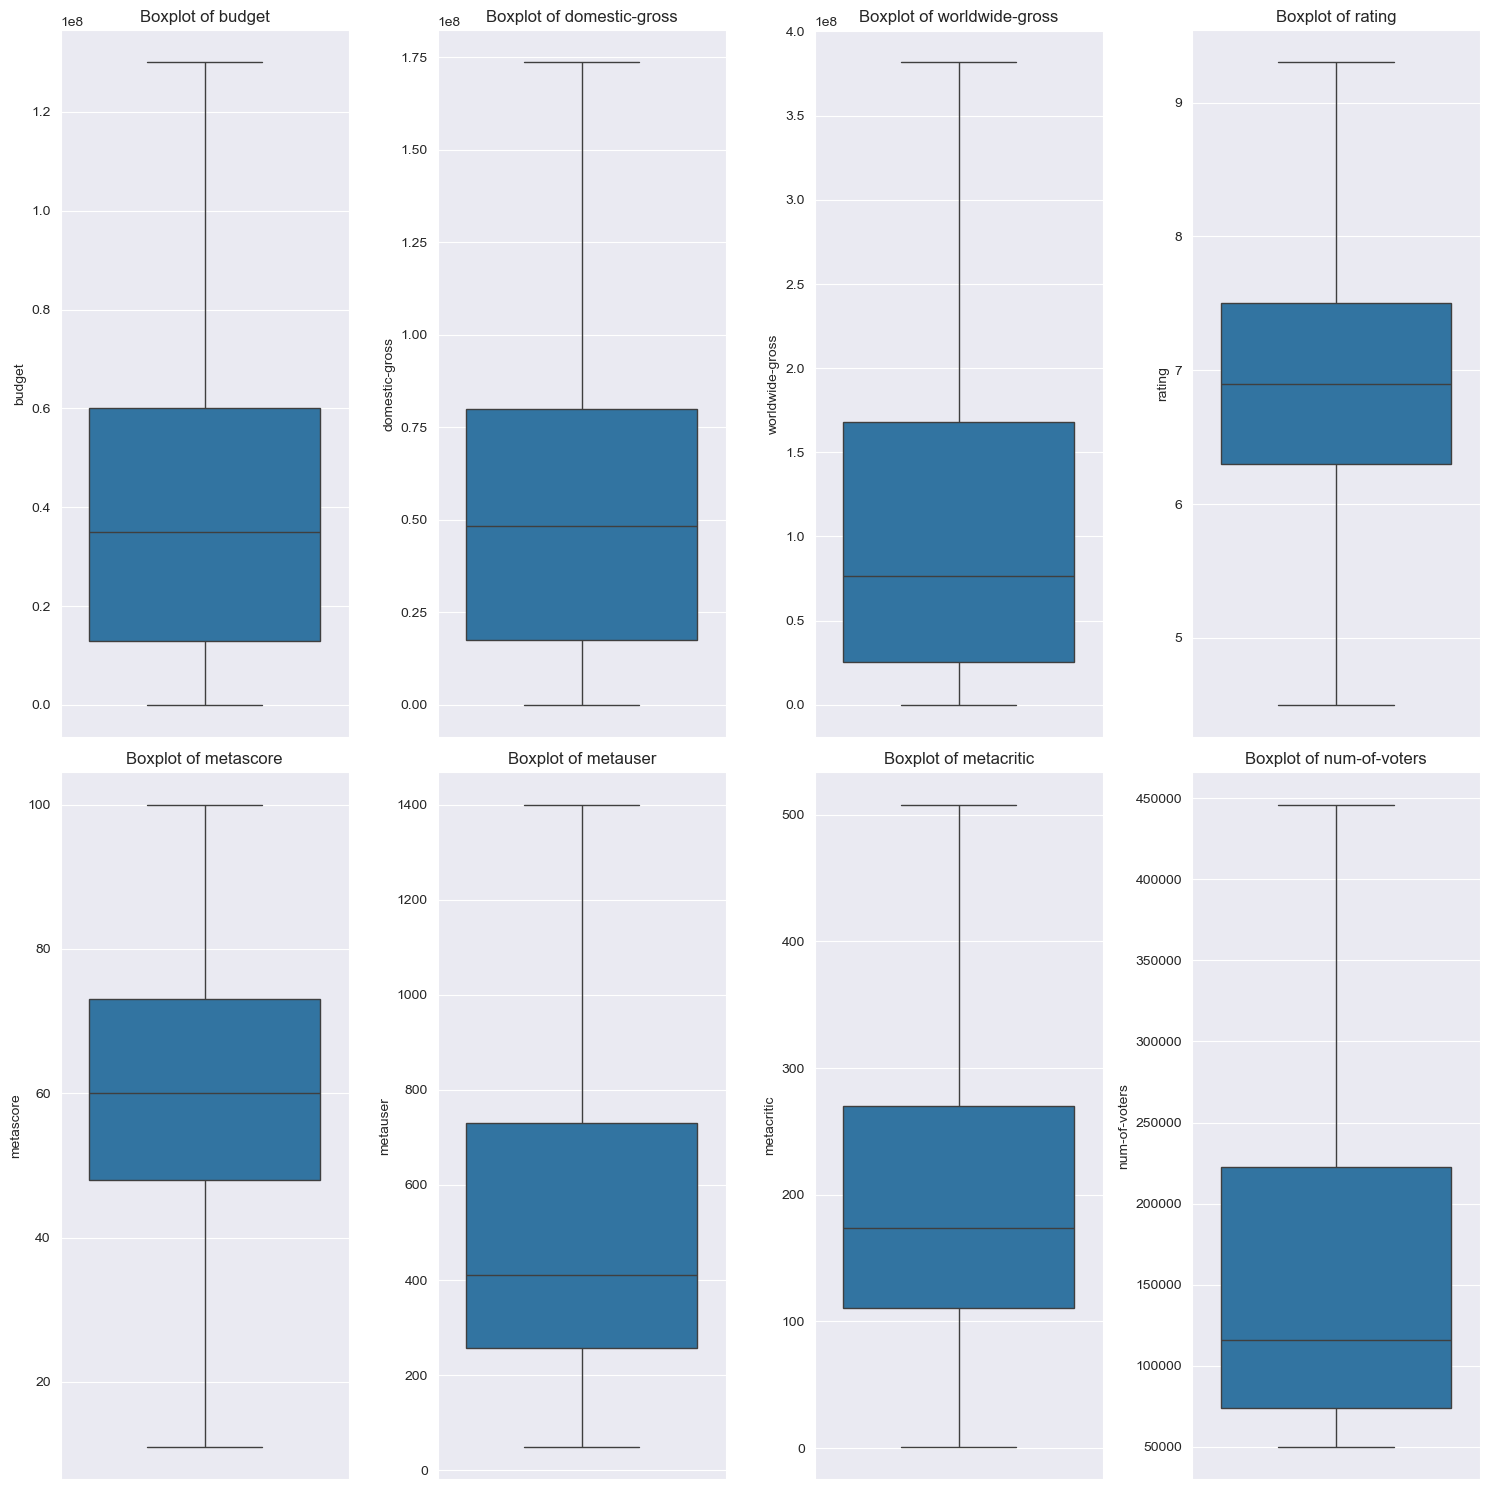

In [28]:
#Outlier detection with boxplot
from matplotlib import pyplot as plt
import seaborn as sns
#Detect outlier using boxplot
fig, axs = plt.subplots(2, 4, figsize=(15, 15))
for i, var in enumerate(numerical_columns):
    sns.boxplot(df[var], ax=axs[i//4, i%4])
    axs[i//4, i%4].set_title('Boxplot of ' + var)
plt.tight_layout()
plt.show()

## Tạo thêm biến từ các biến có sẵn

In [29]:
#Calculate the profit
df['profit'] = df['worldwide-gross'] - df['budget']

In [30]:
df.to_csv('cleaned_movies_data.csv')

# Phân tích dữ liệu

## 1. Phân tích mô tả

In [31]:
#Divide into categorical variables and numerical variables
categorical_columns = ['genres', 'writer', 'language', 'company', 'origin', 'certificate']
numerical_columns = ['budget', 'domestic-gross', 'worldwide-gross', 'rating', 'metascore', 'metauser', 'metacritic', 'profit', 'num-of-voters']

In [32]:
#Display dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4068 entries, 0 to 4076
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   title            4068 non-null   object        
 1   num-of-voters    4068 non-null   int64         
 2   release-year     4068 non-null   datetime64[ns]
 3   certificate      4068 non-null   object        
 4   length           4068 non-null   float64       
 5   genres           4068 non-null   object        
 6   director         4068 non-null   object        
 7   writer           4068 non-null   object        
 8   cast             4068 non-null   object        
 9   language         4068 non-null   object        
 10  company          4068 non-null   object        
 11  origin           4068 non-null   object        
 12  budget           4068 non-null   float64       
 13  domestic-gross   4068 non-null   float64       
 14  worldwide-gross  4068 non-null   float64     

In [33]:
print(f"The dataset contains {df.shape[1]} columns and {df.shape[0]} rows")

The dataset contains 20 columns and 4068 rows


In [34]:
#Display statistics of numeric variables
df.select_dtypes(include='number').describe()

C:\Users\Administrator\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4737: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Users\Administrator\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4737: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Users\Administrator\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4737: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Users\Administrator\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4737: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Users\Administrator\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4737: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Users\Administrator\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4737: UserWarning: Warning: 'par

num-of-voters    length         budget  domestic-gross  \
count      4068.0000 4068.0000      4068.0000       4068.0000   
mean     168277.7018  113.3867  42968819.0838   59164499.1128   
std      124280.6181   21.6530  37465300.4616   51046549.6383   
min       50026.0000   42.0000        18.0000        509.0000   
25%       73812.7500   98.0000  13000000.0000   17592731.0000   
50%      115864.0000  110.0000  35000000.0000   48320889.0000   
75%      222825.5000  124.0000  60000000.0000   80019981.7500   
max      446062.0000  321.0000 130000000.0000  173585516.0000   

       worldwide-gross    rating  metascore  metauser  metacritic  \
count        4068.0000 4068.0000  4068.0000 4068.0000   4068.0000   
mean    118278103.5996    6.8517    60.3864  542.8051    202.4594   
std     118209558.1055    0.8605    17.4271  380.5687    120.6349   
min            67.0000    4.5000    11.0000   49.0000      1.0000   
25%      25243297.5000    6.3000    48.0000  256.0000    111.0000   
50%      76451886.5000    6.9000    60.0000  411.0000    174.0000   
75%     167824819.7500    7.5000    73.0000  730.2500    270.0000   
max     381545846.0000    9.3000   100.0000 1400.0000    508.0000   

               profit  
count       4068.0000  
mean    75309284.5157  
std     96882115.8089  
min   -129821857.0000  
25%      3069962.0000  
50%     42751256.5000  
75%    122400104.5000  
max    379093048.0000

In [35]:
#Display statistics of categories variables
df.select_dtypes(include='object').describe()

title certificate                    genres          director  \
count        4068        4068                      4068              4068   
unique       3982          17                       330              1585   
top     Halloween          15  [Comedy, Drama, Romance]  Steven Spielberg   
freq            3        1590                       157                30   

               writer                             cast language  \
count            4068                             4068     4068   
unique           3520                             3820       43   
top     [Woody Allen]  [Daniel Radcliffe, Emma Watson]  English   
freq               14                                6     3694   

                   company         origin  
count                 4068           4068  
unique                1183             49  
top     Universal Pictures  United States  
freq                   264           2928

In [36]:
df.select_dtypes(include='number').skew()

num-of-voters      1.1788
length             1.3972
budget             1.0443
domestic-gross     0.9323
worldwide-gross    1.0930
rating            -0.3288
metascore         -0.0591
metauser           1.0649
metacritic         0.8552
profit             1.0267
dtype: float64

In [37]:
df.select_dtypes(include='number').kurtosis()

num-of-voters      0.1291
length             4.5998
budget             0.1785
domestic-gross    -0.0504
worldwide-gross    0.0411
rating            -0.1477
metascore         -0.4729
metauser           0.0304
metacritic         0.0613
profit             0.1718
dtype: float64

## 2. Phân tích chẩn đoán và trực quan hoá dữ liệu

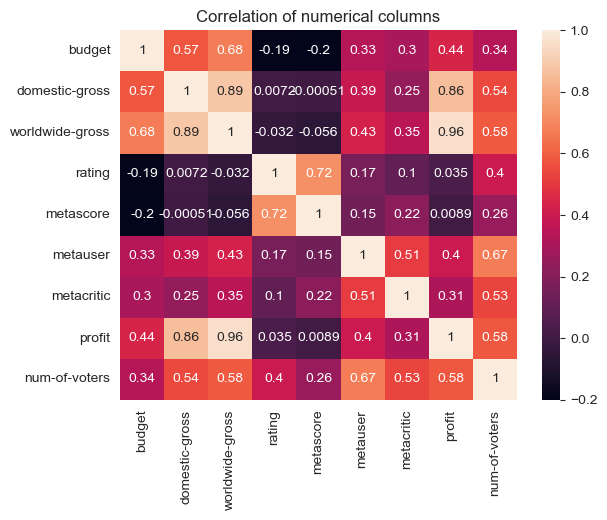

In [38]:
#Plot the correlation heatmap of numerical variable
correlation_matrix = df[numerical_columns].corr()
sns.heatmap(correlation_matrix, annot=True)
plt.title('Correlation of numerical columns')
plt.show()

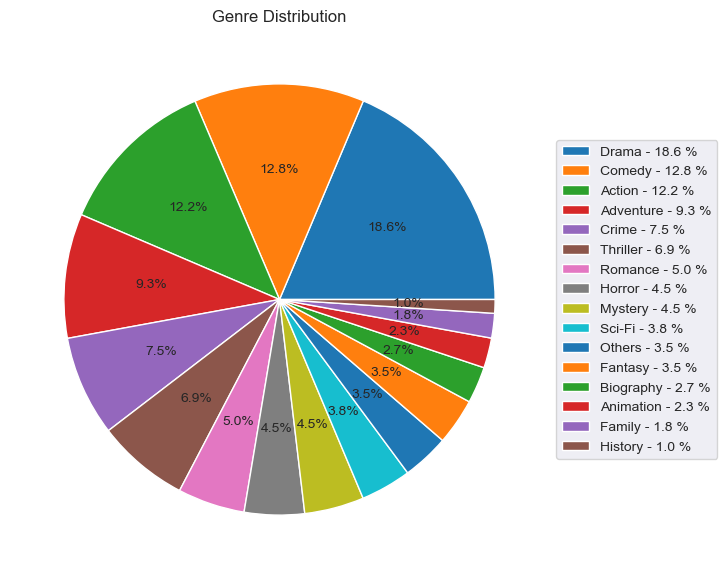

In [39]:
#Split the genres, count and display with pie chart

genres = df['genres'].explode().value_counts()
genres.index = genres.index.where(genres.values > 100, 'Others')
genres = genres.groupby('genres').sum()
genres.sort_values(ascending=False, inplace=True)
plt.figure(figsize=(14, 7))
percentages = 100. * genres / genres.sum()
labels = ['{0} - {1:1.1f} %'.format(i,j) for i,j in zip(genres.index, percentages)]
patches, texts, autotexts= plt.pie(genres.values, autopct='%1.1f%%')
plt.legend(patches, labels, loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.title('Genre Distribution')
plt.show()

<Axes: title={'center': 'Genres distribution over the years'}, xlabel='year', ylabel='release-year'>

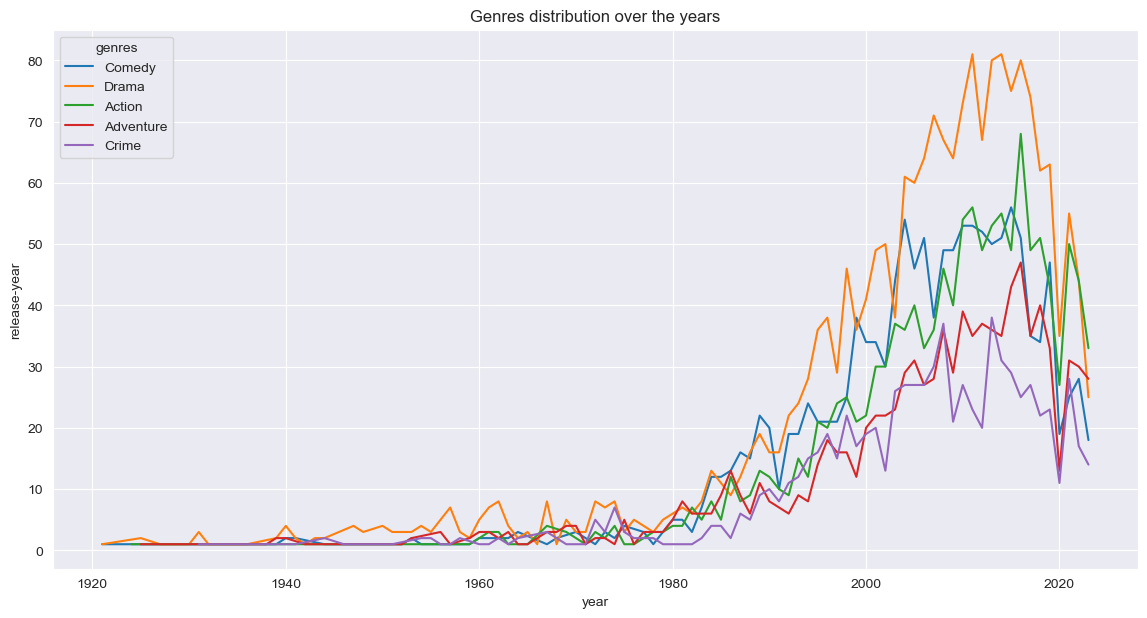

In [40]:
genres_year = df.explode(['genres'])[['genres', 'release-year']]
genres_year['year'] = pd.to_datetime(genres_year['release-year']).dt.year
genres_year = genres_year.groupby(['year', 'genres']).count()
genres_year.reset_index(inplace=True)

genres_year = genres_year.where(genres_year['genres'].isin(list(genres.head(5).index)))
plt.figure(figsize=(14,7))
plt.title('Genres distribution over the years')
sns.lineplot(x = genres_year.year, y = genres_year['release-year'], hue=genres_year.genres)

In [41]:
# Load the countries geometry
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Merge with your data
df['origin'] = df['origin'].str.title()
countries_movies_num = df.groupby('origin').agg({'title': 'count'}).reset_index(drop=False)
country_name = {
    'Czech Republic': 'Czechia',
    'Federal Republic Of Yugoslavia': 'Serbia',
    'Soviet Union': 'Russia',
    'United States': 'United States of America',
    'West Germany': 'Germany',
    'Yugoslavia': 'Serbia',
}
countries_movies_num.replace(country_name.keys(), country_name.values(), inplace=True)
merged = pd.merge(countries_movies_num, world, left_on='origin', right_on='name')
merged.rename(columns={'title': 'Number of movies'}, inplace=True)
fig = px.choropleth(merged, locations='iso_a3', color='Number of movies', hover_name='origin',
                    projection='natural earth', title='Number of movies in each country')

fig.show()


C:\Users\Administrator\AppData\Local\Temp\ipykernel_13424\3365343799.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


In [42]:
# Convert any origin different from United States or United Kingdom to Others
movies_per_origin = df['origin'].value_counts()
us_uk = movies_per_origin.index[:2]
df['origin'] = df['origin'].where(df['origin'].isin(us_uk), 'Others')
df['origin'].unique()

array(['United Kingdom', 'United States', 'Others'], dtype=object)

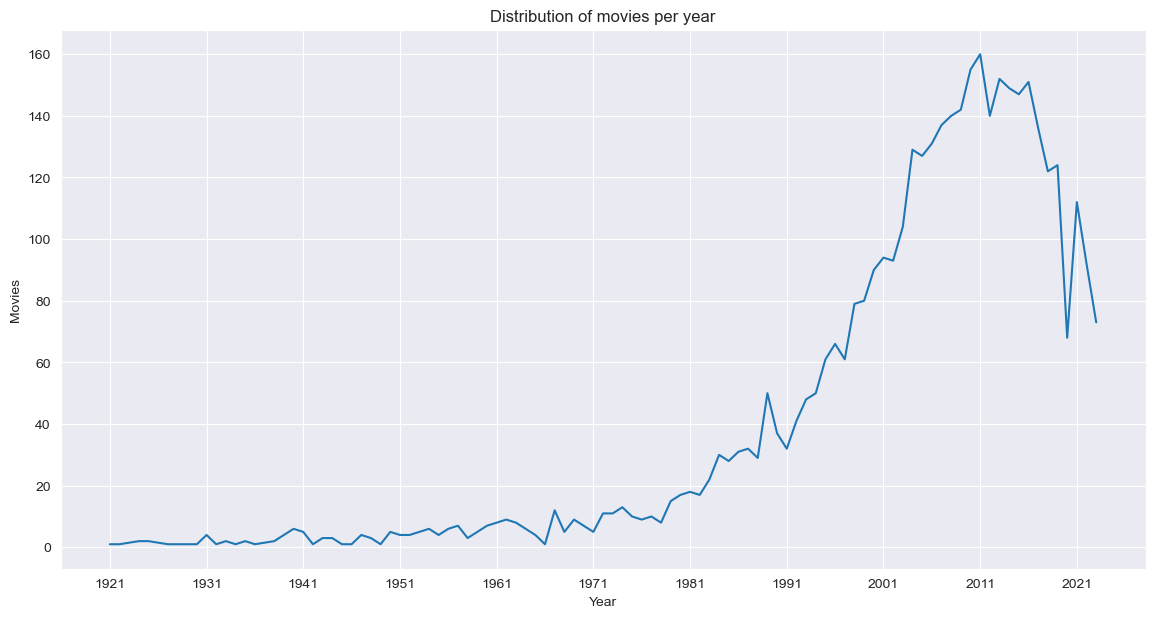

In [43]:
# Plot number of movies released over the year
yearly_rating = pd.to_datetime(df['release-year']).dt.year.value_counts()
plt.figure(figsize=(14,7))
sns.lineplot(x = yearly_rating.index,y= yearly_rating.values)
plt.title('Distribution of movies per year')
plt.xlabel("Year")
plt.ylabel('Movies')
plt.xticks(np.arange(yearly_rating.index.min(), yearly_rating.index.max(), step=10))
plt.show()

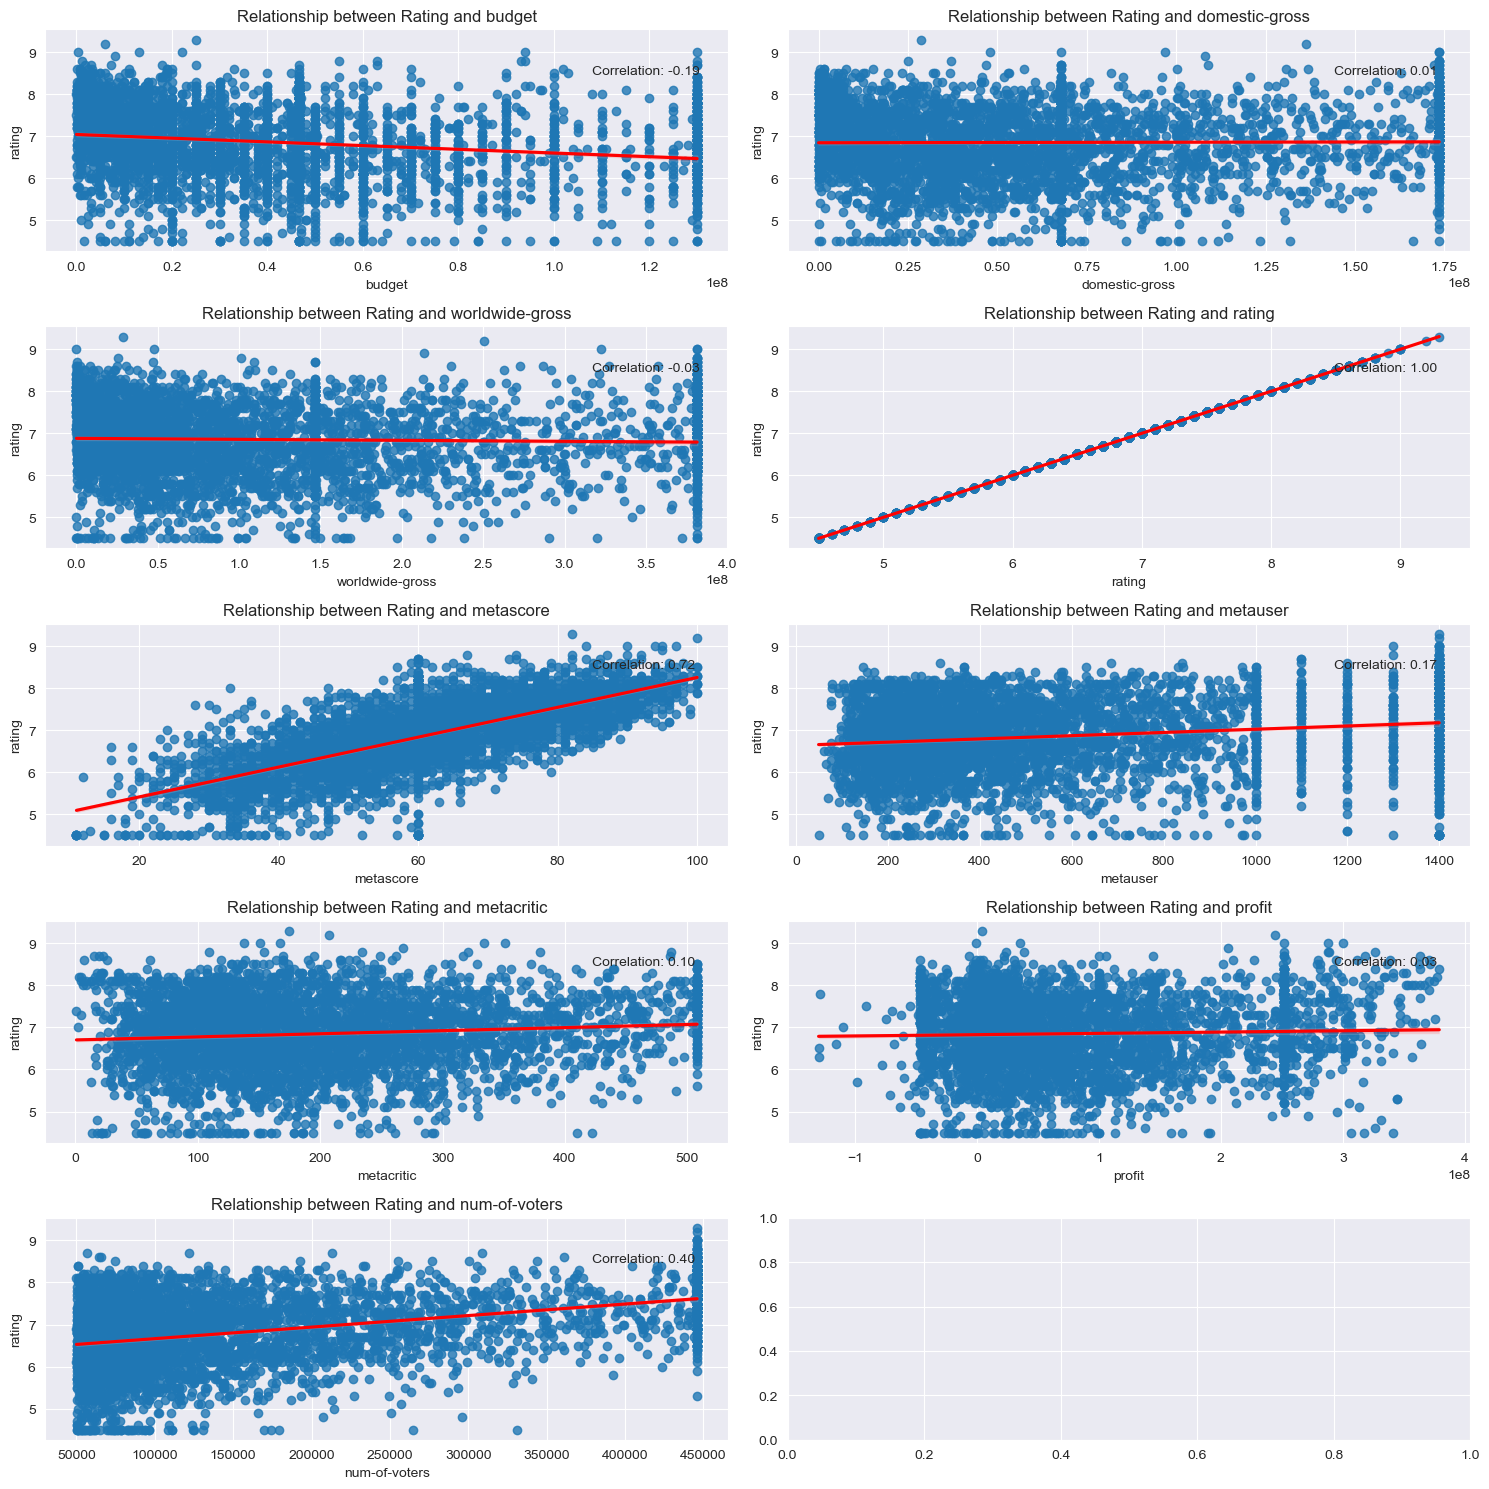

In [44]:
# Calculate the correlation between numerical variables and rating
fig, axs = plt.subplots(5, 2, figsize=(15, 15))
for i, var in enumerate(numerical_columns):
    sns.regplot(x=var, y='rating', data=df, line_kws={'color': 'red'}, ax=axs[i//2, i%2])
    axs[i//2, i%2].set_title('Relationship between Rating and ' + var)
    correlation = np.corrcoef(df[var], df['rating'])[0, 1]
    axs[i//2, i%2].text(0.8, 0.8, 'Correlation: {:.2f}'.format(correlation), transform=axs[i//2, i%2].transAxes)
plt.tight_layout()
plt.show()

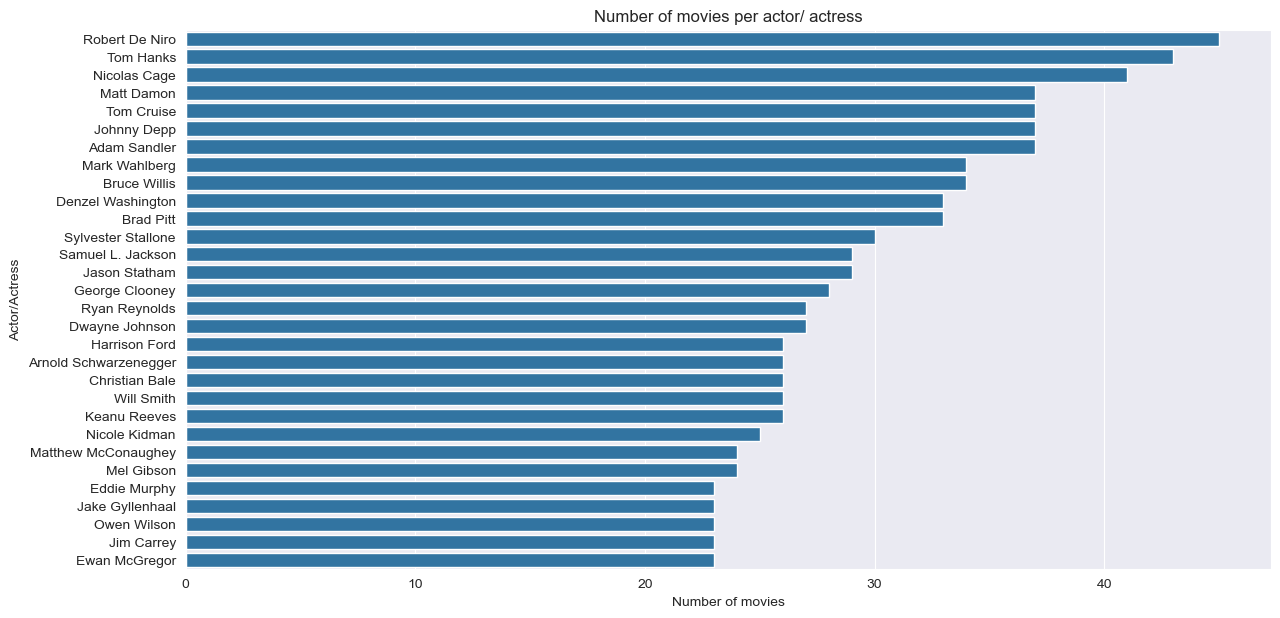

In [45]:
# Plot top 30 actors/actresses that featured in the most movies

cast_df = df.explode(column=['cast']).groupby('cast').agg({'rating':'count'})
cast_df.sort_values(by='rating', ascending=False, inplace=True)
cast_df = cast_df.head(30)
plt.figure(figsize=(14,7))
sns.barplot(y=cast_df.index, x=cast_df['rating'])
plt.title('Number of movies per actor/ actress')
plt.xlabel('Number of movies')
plt.ylabel('Actor/Actress')
plt.show()

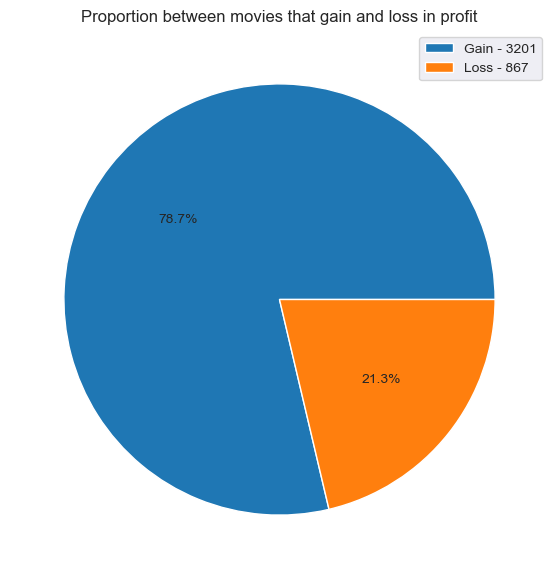

In [46]:
profit = df['profit'].apply(lambda x: 'Gain' if x >0 else 'Loss')
profit = pd.DataFrame(profit).value_counts().reset_index()

plt.figure(figsize=(14,7))
ax = plt.pie(profit['count'], autopct='%1.1f%%')
labels = ['{0} - {1}'.format(i,j) for i,j in zip(profit['profit'], profit['count'])]
plt.title("Proportion between movies that gain and loss in profit")
plt.legend(labels)
plt.show()

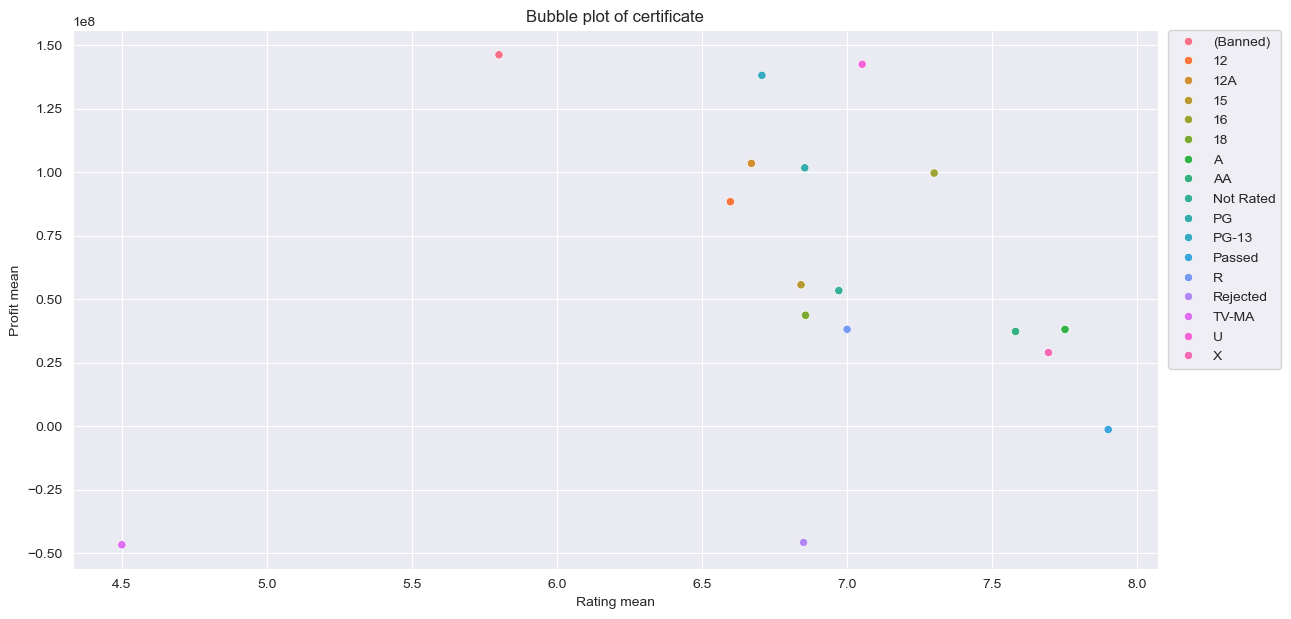

In [47]:
# Scatter plot of certificate base on average rating and average profit
certificate_df = df.groupby('certificate').agg({'rating': 'mean', 'profit': 'mean'})
plt.figure(figsize=(14,7))
sns.scatterplot(x='rating',
                y='profit',
                # size="body_mass_g", 
                sizes=(20, 500),
                alpha=1,
                hue=certificate_df.index,
                data=certificate_df)
plt.legend(bbox_to_anchor=(1.01, 1), borderaxespad=0)

# Put the legend out of the figure 
plt.xlabel("Rating mean")
plt.ylabel("Profit mean")
plt.title("Bubble plot of certificate")
plt.show()

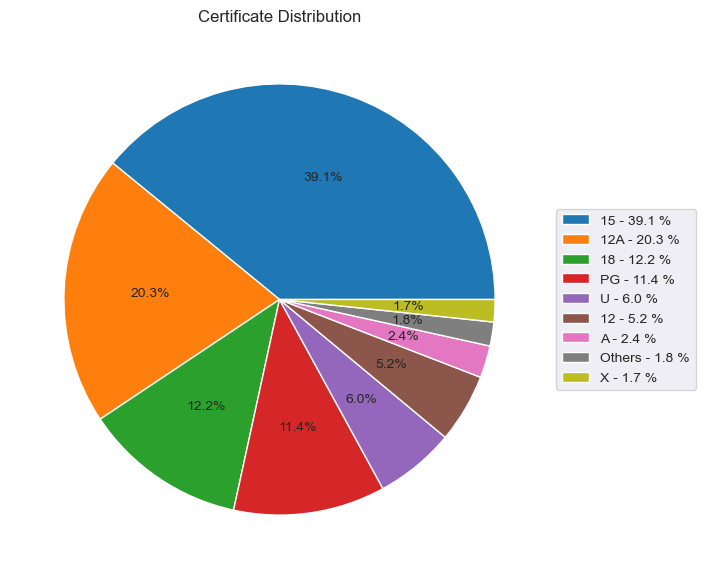

In [48]:
cer = df['certificate'].value_counts()
cer.index = cer.index.where(cer.values > 50, 'Others')
cer = cer.groupby('certificate').sum()
cer.sort_values(ascending=False, inplace=True)
plt.figure(figsize=(14, 7))
percentages = 100. * cer / cer.sum()
labels = ['{0} - {1:1.1f} %'.format(i,j) for i,j in zip(cer.index, percentages)]
patches, texts, autotexts= plt.pie(cer.values, autopct='%1.1f%%')
plt.legend(patches, labels, loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.title('Certificate Distribution')
plt.show()

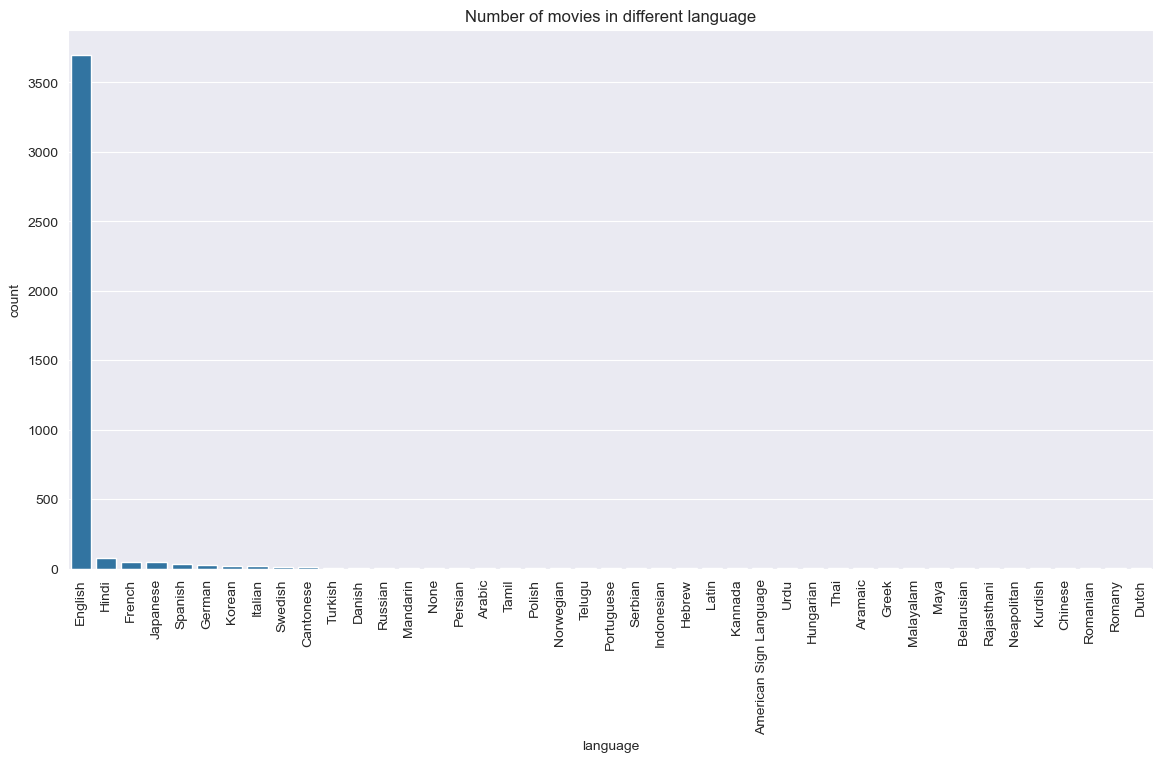

In [49]:
# Number of languages used in movies
plt.show()
lang_df = df['language'].value_counts()
plt.figure(figsize=(14, 7))
sns.barplot(lang_df)
plt.xticks(rotation=90)
plt.title('Number of movies in different language')
plt.show()

In [50]:
# Convert any language other than English to others
df['language'] = df['language'].where(df['language'].isin(['English']), 'Others')

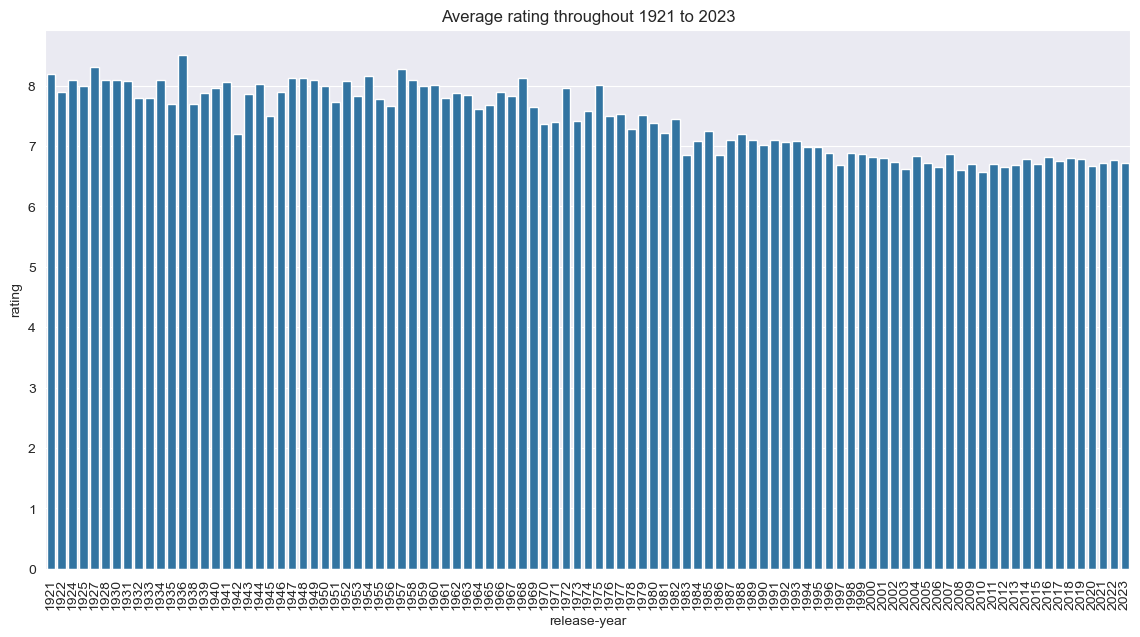

In [51]:
rating_by_year = df.groupby(pd.to_datetime(df['release-year']).dt.year).agg({'rating': 'mean'})
plt.figure(figsize=(14,7))
sns.barplot(x=rating_by_year.index, y=rating_by_year['rating'])
plt.title("Average rating throughout 1921 to 2023")
plt.xticks(rotation=90)
plt.show()

In [52]:
# Drop release-year column
df.drop(columns=['release-year'], inplace=True)

# Xây dựng model dự đoán rating

In [53]:
# Make a copy of the df for modelling purpose
prediction_df = df.copy()

In [54]:
# Drop columns with names
prediction_df.drop(columns=['title', 'director', 'writer', 'cast', 'company',], inplace=True)

In [55]:
#Create dummies column for categories column
genre_dummies = pd.get_dummies(df['genres'].explode()).groupby(level=0).sum()
lang_dummies = pd.get_dummies(df['language']).groupby(level=0).sum()
origin_dummies = pd.get_dummies(df['origin']).groupby(level=0).sum()
cer_dummies = pd.get_dummies(df['certificate']).groupby(level=0).sum()
prediction_df = pd.concat([prediction_df, genre_dummies, lang_dummies, origin_dummies, cer_dummies],axis=1)
prediction_df.drop(columns = ['genres', 'certificate', 'language', 'origin'], inplace=True)

In [64]:
#Model for predicting rating
def rating_predicting_model(features, target, model):
    # Split test set and training set
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
    #Define the pipeline
    pl = Pipeline([
        ('scale', StandardScaler()),
        ('model', model)
    ])

    pl.fit(X_train, y_train)

    y_pred = pl.predict(X_test)

    y_test.to_numpy()

    rmse = sqrt(mean_squared_error(y_test, y_pred))
    score = r2_score(y_test, y_pred)
    cval_score = cross_val_score(model, features, target, cv = 5)
    print(f'Cross-validation scores: {cval_score}')
    print(f'Average score: {cval_score.mean()}')
    print(f'Test RMSE: {rmse:.3f}')
    print(f'Test r2 score: {score:.3f}\n')

In [65]:
features = prediction_df.drop(columns=['rating'])
target = prediction_df['rating']
print('Random Forest Regressor: ')
rating_predicting_model(features, target, RandomForestRegressor())
print('Gradient Boosting Regressor: ')
rating_predicting_model(features, target, GradientBoostingRegressor())
print('Linear Regression')
rating_predicting_model(features, target, LinearRegression())
print('Decision Tree Regressor: ')
rating_predicting_model(features, target, DecisionTreeRegressor())
print('Support Vector Regression: ')
rating_predicting_model(features, target, SVR())
print('KNeighbors Regressor: ')
rating_predicting_model(features, target, KNeighborsRegressor())

Random Forest Regressor: 
Cross-validation scores: [0.72650371 0.72847856 0.69325658 0.69172904 0.71414161]
Average score: 0.7108218995673747
Test RMSE: 0.427
Test r2 score: 0.772

Gradient Boosting Regressor: 
Cross-validation scores: [0.74420879 0.73488428 0.69719967 0.70486166 0.72730845]
Average score: 0.7216925717203184
Test RMSE: 0.433
Test r2 score: 0.766

Linear Regression
Cross-validation scores: [0.70413265 0.70759546 0.69127005 0.68577171 0.71846168]
Average score: 0.7014463103694868
Test RMSE: 5090423959.627
Test r2 score: -32348009999634862080.000

Decision Tree Regressor: 
Cross-validation scores: [0.37760517 0.42139485 0.43478313 0.39725918 0.44179042]
Average score: 0.4145665501256608
Test RMSE: 0.647
Test r2 score: 0.478

Support Vector Regression: 
Cross-validation scores: [0.17710004 0.09606182 0.16296448 0.13875673 0.12358977]
Average score: 0.13969456685501902
Test RMSE: 0.437
Test r2 score: 0.761

KNeighbors Regressor: 
Cross-validation scores: [0.0974213  0.09815